In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider, Dropdown
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl

mpl.rcParams['text.usetex'] = False  # 禁用 LaTeX 渲染
plt.rcParams['font.family'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def bivariate_normal_visualization(mu_x=0, mu_y=0, sigma_x=1, sigma_y=1, rho=0, 
                                 section='x轴切面', slice_value=0):
    """
    可视化二维正态分布及其边际分布
    """
    # 计算坐标轴范围（基于参数动态调整，但固定不变）
    max_sigma = max(sigma_x, sigma_y)
    x_min, x_max = -4, 4  # 固定x范围，扩大显示区域
    y_min, y_max = -4, 4  # 固定y范围，扩大显示区域
    
    # 生成网格数据（使用动态参数）
    x = np.linspace(mu_x - 3*sigma_x, mu_x + 3*sigma_x, 100)  # 减小网格范围至3σ
    y = np.linspace(mu_y - 3*sigma_y, mu_y + 3*sigma_y, 100)  # 减小网格范围至3σ
    X, Y = np.meshgrid(x, y)
    
    # 计算二维正态分布概率密度
    rho_sq = rho ** 2
    sigma_x_sq = sigma_x ** 2
    sigma_y_sq = sigma_y ** 2
    denom = 2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho_sq)
    numerator = ((X - mu_x) **2 / sigma_x_sq - 
                2 * rho * (X - mu_x) * (Y - mu_y) / (sigma_x * sigma_y) + 
                (Y - mu_y)** 2 / sigma_y_sq)
    Z = np.exp(-numerator / (2 * (1 - rho_sq))) / denom
    
    # 计算z轴范围（基于最大可能值，但设置上限避免过高）
    z_max = min(0.5, 1 / (2 * np.pi * min(sigma_x, sigma_y) ** 2))  # 限制z轴上限
    z_min = 0
    
    # 创建图形和子图
    fig = plt.figure(figsize=(18, 8))
    
    # 1. 三维曲面图（固定坐标轴范围，优化视角）
    ax1 = fig.add_subplot(231, projection='3d')
    ax1.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.8, rstride=2, cstride=2)  # 降低网格密度
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title(f'二维正态分布联合概率密度 (μ_x={mu_x}, μ_y={mu_y})')
    ax1.set_xlim(x_min, x_max)  # 固定x轴范围
    ax1.set_ylim(y_min, y_max)  # 固定y轴范围
    ax1.set_zlim(z_min, z_max)  # 固定z轴范围
    ax1.view_init(elev=30, azim=45)  # 优化视角
    
    # 2. 等高线图
    ax2 = fig.add_subplot(232)
    contour = ax2.contour(X, Y, Z, 10, cmap=cm.viridis)
    ax2.clabel(contour, inline=True, fontsize=8)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title(f'等高线图 (相关系数 ρ={rho}, σ_x={sigma_x}, σ_y={sigma_y})')
    ax2.grid(True, alpha=0.3)
    
   # 3. 切面图与条件分布（仅修改此部分）
    ax3 = fig.add_subplot(233)
    
    if section == 'x轴切面':
        mask = np.abs(X - slice_value) < 0.1
        y_conditional = Y[mask].flatten()
        z_conditional = Z[mask].flatten()
        
        # 关键修改：对截面数据进行归一化处理
        if len(z_conditional) > 0:
            # 计算归一化因子（确保曲线下方面积=1）
            dx = y_conditional[1:] - y_conditional[:-1]
            avg_dx = np.mean(dx) if len(dx) > 0 else 1
            norm_factor = np.sum(z_conditional) * avg_dx
            z_conditional /= norm_factor if norm_factor > 0 else 1
        
        # 排序以确保绘图正确
        idx = np.argsort(y_conditional)
        y_conditional = y_conditional[idx]
        z_conditional = z_conditional[idx]
        
        ax3.plot(y_conditional, z_conditional, 'b-', linewidth=2, label=f'X={slice_value} 截面')
        
        # 计算条件分布的理论曲线
        cond_mean = mu_y + rho * (sigma_y/sigma_x) * (slice_value - mu_x)
        cond_var = sigma_y_sq * (1 - rho**2)
        y_theory = np.linspace(mu_y - 5*sigma_y, mu_y + 5*sigma_y, 100)
        cond_pdf = 1/(np.sqrt(cond_var) * np.sqrt(2*np.pi)) * np.exp(-(y_theory - cond_mean)**2/(2*cond_var))
        ax3.plot(y_theory, cond_pdf, 'r--', linewidth=2, 
                 label=f'条件分布 N({cond_mean:.2f}, {cond_var:.2f})')
        
        # 添加参数标注
        ax3.text(0.05, 0.95, 
                f'μ_x={mu_x}, μ_y={mu_y}\nσ_x={sigma_x}, σ_y={sigma_y}\nρ={rho}', 
                transform=ax3.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8),
                verticalalignment='top')
        
        ax3.set_xlabel('Y')
        ax3.set_ylabel('概率密度')
        ax3.set_title(f'X={slice_value} 截面与对应条件分布')
    
    elif section == 'y轴切面':
        mask = np.abs(Y - slice_value) < 0.1
        x_conditional = X[mask].flatten()
        z_conditional = Z[mask].flatten()
        
        # 关键修改：对截面数据进行归一化处理
        if len(z_conditional) > 0:
            dx = x_conditional[1:] - x_conditional[:-1]
            avg_dx = np.mean(dx) if len(dx) > 0 else 1
            norm_factor = np.sum(z_conditional) * avg_dx
            z_conditional /= norm_factor if norm_factor > 0 else 1
        
        # 排序以确保绘图正确
        idx = np.argsort(x_conditional)
        x_conditional = x_conditional[idx]
        z_conditional = z_conditional[idx]
        
        ax3.plot(x_conditional, z_conditional, 'b-', linewidth=2, label=f'Y={slice_value} 截面')
        
        # 计算条件分布的理论曲线
        cond_mean = mu_x + rho * (sigma_x/sigma_y) * (slice_value - mu_y)
        cond_var = sigma_x_sq * (1 - rho**2)
        x_theory = np.linspace(mu_x - 5*sigma_x, mu_x + 5*sigma_x, 100)
        cond_pdf = 1/(np.sqrt(cond_var) * np.sqrt(2*np.pi)) * np.exp(-(x_theory - cond_mean)**2/(2*cond_var))
        ax3.plot(x_theory, cond_pdf, 'r--', linewidth=2, 
                 label=f'条件分布 N({cond_mean:.2f}, {cond_var:.2f})')
        
        # 添加参数标注
        ax3.text(0.05, 0.95, 
                f'μ_x={mu_x}, μ_y={mu_y}\nσ_x={sigma_x}, σ_y={sigma_y}\nρ={rho}', 
                transform=ax3.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8),
                verticalalignment='top')
        
        ax3.set_xlabel('X')
        ax3.set_ylabel('概率密度')
        ax3.set_title(f'Y={slice_value} 截面与对应条件分布')
    
  
    elif section == '任意斜率切面':
        mask = np.abs(X - Y - slice_value) < 0.1
        x_marginal = X[mask].flatten()
        z_marginal = Z[mask].flatten()
    
        # 关键修复：按 x 坐标排序
        sort_idx = np.argsort(x_marginal)
        x_marginal = x_marginal[sort_idx]
        z_marginal = z_marginal[sort_idx]
    
        ax3.plot(x_marginal, z_marginal, 'b-', linewidth=2, alpha=0.7, 
                label=f'切面 X-Y={slice_value}')
    
        # 添加参数标注
        ax3.text(0.05, 0.95, 
                f'μ_x={mu_x}, μ_y={mu_y}\nσ_x={sigma_x}, σ_y={sigma_y}\nρ={rho}', 
                transform=ax3.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8),
                verticalalignment='top')
    
        ax3.set_xlabel('X')
        ax3.set_ylabel('概率密度')
        ax3.set_title(f'任意斜率切面 X-Y={slice_value}')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# 创建交互式控件（保持不变）
mu_x_slider = FloatSlider(min=-1, max=1, step=0.2, value=0, description='μ_x')
mu_y_slider = FloatSlider(min=-1, max=1, step=0.2, value=0, description='μ_y')
sigma_x_slider = FloatSlider(min=0.5, max=3, step=0.1, value=1, description='σ_x')
sigma_y_slider = FloatSlider(min=0.5, max=3, step=0.1, value=1, description='σ_y')
rho_slider = FloatSlider(min=-0.999, max=0.999, step=0.001, value=0, description='ρ 相关系数')

section_dropdown = Dropdown(
    options=['x轴切面', 'y轴切面', '任意斜率切面'],
    value='x轴切面',
    description='切面方向:',
)

slice_value_slider = FloatSlider(min=-3, max=3, step=0.5, value=0, description='切面位置')

# 创建交互式界面
interactive_plot = interactive(
    bivariate_normal_visualization,
    mu_x=mu_x_slider,
    mu_y=mu_y_slider,
    sigma_x=sigma_x_slider,
    sigma_y=sigma_y_slider,
    rho=rho_slider,
    section=section_dropdown,
    slice_value=slice_value_slider,
)

# 调整输出高度
output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='μ_x', max=1.0, min=-1.0, step=0.2), FloatSlider(valu…

In [2]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import multivariate_normal

# 1. 定义二维正态分布参数
mean = [0, 0]  # 均值
cov = [[1, 0.5], [0.5, 1]]  # 协方差矩阵（控制形状和倾斜度）

# 2. 生成网格数据
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# 3. 计算二维正态分布的概率密度
Z = multivariate_normal.pdf(pos, mean=mean, cov=cov)

# 4. 创建3D表面图（支持旋转交互）
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

# 设置标题和坐标轴
fig.update_layout(
    title='二维正态分布的3D可视化（可旋转）',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='概率密度'
    ),
    width=800,
    height=600
)

# 显示图形（在Jupyter或浏览器中可鼠标拖动旋转）
fig.show()

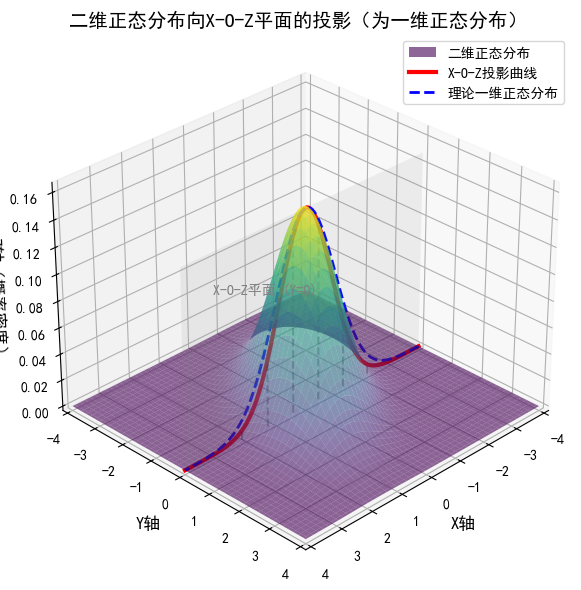

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal, norm

# 设置中文字体
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False

# 1. 定义二维正态分布参数
mean = [0, 0]  # 均值 (μx, μy)
cov = [[1, 0.6], [0.6, 1.5]]  # 协方差矩阵（控制分布形态）

# 2. 生成基础网格数据
x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = multivariate_normal.pdf(pos, mean=mean, cov=cov)  # 二维正态分布密度

# 3. 计算X-O-Z平面投影（固定Y=0时的截面，即向X-O-Z平面的投影）
y_proj = 0  # 投影到Y=0的平面
# 在X-O-Z平面上的截面曲线（固定Y=0，Z随X变化）
z_xoz = multivariate_normal.pdf(np.dstack((x, np.zeros_like(x))), mean=mean, cov=cov).flatten()
# 对应的理论一维正态分布（验证投影是正态分布）
x_norm = norm.pdf(x, loc=mean[0], scale=np.sqrt(cov[0][0]))  # 理论值


# 4. 绘制3D图形及投影
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 4.1 绘制原始二维正态分布的3D表面（草帽图）
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6, 
                       linewidth=0, antialiased=True, label='二维正态分布')

# 4.2 绘制X-O-Z平面（Y=0的平面，半透明）
xx, zz = np.meshgrid(x, np.linspace(0, np.max(Z), 20))
yy = np.zeros_like(xx)  # Y=0平面
ax.plot_surface(xx, yy, zz, color='gray', alpha=0.1, shade=False)
ax.text(3, 0, np.max(Z)*0.8, 'X-O-Z平面 (Y=0)', color='gray')

# 4.3 绘制X-O-Z平面上的投影曲线（固定Y=0的截面）
ax.plot(x, np.zeros_like(x), z_xoz, 'r-', linewidth=3, label='X-O-Z投影曲线')

# 4.4 绘制理论一维正态分布曲线（用于验证投影是正态分布）
# 将理论曲线绘制在X-O-Z平面上，稍高于投影曲线以区分
ax.plot(x, np.zeros_like(x), x_norm * (np.max(z_xoz)/np.max(x_norm)), 
        'b--', linewidth=2, label='理论一维正态分布')

# 4.5 添加投影示意线（从3D表面到X-O-Z平面的垂线）
# 选取若干点绘制垂线，体现"投影"的几何意义
sample_x = np.linspace(-3, 3, 8)  # 采样X值
for xi in sample_x:
    # 找到该X值对应的Y=0处的Z值（投影点）
    z_proj = multivariate_normal.pdf([xi, 0], mean=mean, cov=cov)
    # 绘制从3D表面（Y=0处）到X-O-Z平面的垂线
    ax.plot([xi, xi], [0, 0], [0, z_proj], 'k--', alpha=0.3)


# 5. 设置坐标轴和标题
ax.set_title('二维正态分布向X-O-Z平面的投影（为一维正态分布）', fontsize=14)
ax.set_xlabel('X轴', fontsize=12)
ax.set_ylabel('Y轴', fontsize=12)
ax.set_zlabel('Z轴（概率密度）', fontsize=12)
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_zlim(0, np.max(Z)*1.1)

# 添加图例
ax.legend(loc='upper right')

# 设置初始视角（便于观察X-O-Z平面）
ax.view_init(elev=30, azim=45)  # 可调整elev和azim改变视角

plt.tight_layout()
plt.show()